## Fitting Vector Fields

The ICNN parametrizes a convex surface, which can be associated with a 2D gradient i.e. a 2D vector field. This vector field has a globally attracting equilibrium point (located at the convex function's minimum). 

Let's try fitting the potential field with this vector field. 

## Fitting Limit Cycles

We generate paired observations of $(x, \dot x)$ for a few different dynamical systems

### Testing Potential Field Parametrization: Simple 2D Oscillator

We start with a simple 2D oscillator to sanity-check our implementation of the potential-field formulation of limit cycles. Note that by itself, it can only represent convex loops. 

[array([0.18620159, 0.44758152]), array([-0.61633971,  1.02438873]), array([0.10765486, 1.18160755]), array([-0.21992384, -1.0835051 ]), array([-1.14657234,  0.39730014])]


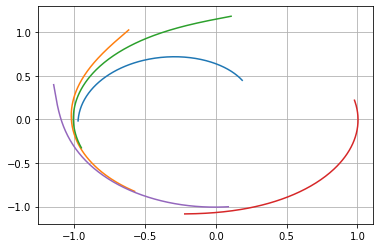

In [1]:
import numpy as np
from torch_vector_field import vector_field, utilities, plotting 

def simple_rot_v(x: np.ndarray) -> np.ndarray:
    x1, x2 = x[...,0], x[...,1]
    r = x1 ** 2 + x2 ** 2
    dx1 = x1 - x2 - x1 * r
    dx2 = x1 + x2 - x2 * r
    # Invert direction to accommodate gradient descent
    dx = - np.stack([dx1, dx2], axis=-1)
    return dx

v = vector_field.FunctionalVectorField(simple_rot_v)

x0s = [np.random.uniform(-1.2, 1.2, size=(2,)) for i in range(5)]
print(x0s)
hs = utilities.simulate_trajectories(v, x0s, step_size=0.01, num_iters = 200)
plotting.plot_histories(hs)



In [2]:
coords = np.linspace(-2, 2, 51)
x1s, x2s = np.meshgrid(coords, coords)
xs = np.vstack([x1s.ravel(), x2s.ravel()]).T
print(xs.shape)

dot_xs = v.get_gradient(xs)
print(dot_xs.shape)

(2601, 2)
(2601, 2)


In [3]:
import torch

full_ds = torch.utils.data.TensorDataset(
    torch.from_numpy(xs.astype(np.float32)), 
    torch.from_numpy(dot_xs.astype(np.float32))
)
train_len = int(xs.shape[0] * 0.8)
test_len = xs.shape[0] - train_len

train_ds, test_ds = torch.utils.data.random_split(full_ds, [train_len, test_len])

train_loader = torch.utils.data.DataLoader(train_ds, batch_size = 32)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32)

Now we need to define the parametrization of the vector field. 


In [50]:
import icnn
import torch
import torch.nn as nn
from torch.autograd.functional import jacobian
from functorch import make_functional_with_buffers, vmap, grad, jacfwd

class RotationalField(nn.Module):
    def __init__(self):
        super(RotationalField, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 8),
            nn.ELU(),
            nn.Linear(8, 1)
        )

    def forward(self, x_unit, r):
        magnitude = self.net(torch.cat([r, x_unit], dim=-1))
        x1_unit, x2_unit = x_unit[...,0].unsqueeze(-1), x_unit[...,1].unsqueeze(-1)
        v_unit = torch.cat([x2_unit, -x1_unit], dim=-1)
        return magnitude * v_unit

    def reset_parameters(self):
        def reset_p(layer):
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()
        self.net.apply(reset_p)

class CombinedVectorField(nn.Module):
    def __init__(self, p_field, r_field):
        super(CombinedVectorField, self).__init__()
        self.r_field = r_field
        self.p_field = p_field
        p_field_fn, p_field_params, p_field_buffers = make_functional_with_buffers(p_field)

        def p_forward_fn(x):
            """ x is assumed not to have the batch dimension """ 
            r = torch.linalg.norm(x, dim=-1, keepdim=True)
            x_unit = x / r
            out = p_field_fn(p_field_params, p_field_buffers, x_unit, r)
            out = out.squeeze() # Function must return scalar 
            return out

        self.p_forward_fn = p_forward_fn
        self.grad_p_fn = grad(p_forward_fn)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """ Predict xdot given x """
        r = torch.linalg.norm(x, dim=-1, keepdim=True)
        x_unit = x / r            
        # Negative gradient of potential fn to attract towards limit cycle
        neg_dp = - vmap(self.grad_p_fn)(x)
        dr = self.r_field(x_unit, r)
        return neg_dp + dr

class SmoothTransformationVectorField(nn.Module):
    def __init__(self, v, f):
        super(SmoothTransformationVectorField, self).__init__()
        self.v = v
        self.f = f

        f_fn, f_params, f_buffers = make_functional_with_buffers(f)

        def f_forward_fn(x):
            """ x is assumed not to have the batch dimension """ 
            return f_fn(f_params, f_buffers, x)

        self.grad_f_fn = jacfwd(f_forward_fn)

    def forward(self, x):

        Df = vmap(self.grad_f_fn)(x)
        Df_inv = vmap(torch.linalg.inv)(Df)
        vfx =  self.v(self.f(x))
        out = vmap(lambda x, y: x @ y)(Df_inv, vfx)
        if torch.isnan(Df).any() \
            or torch.isnan(Df_inv).any() \
            or torch.isnan(vfx).any() \
            or torch.isnan(out).any():
            print("Df is ", Df)
            print("Df_inv is ", Df_inv)
            print("x is ", x)
            print("self.f(x) is ", self.f(x))
            print("vfx is ", vfx)
            print("out is ", out)
        return out

potential_field = icnn.PartiallyInputConvexNeuralNetwork([2,8,1], [1,8,1])
potential_field.reset_parameters()
rotational_field = RotationalField()
rotational_field.reset_parameters()  
combined_field = CombinedVectorField(potential_field, rotational_field)

smooth_transform = nn.Sequential(
    nn.Linear(2, 8),
    nn.ELU(),
    nn.Linear(8, 2)
)

net = SmoothTransformationVectorField(combined_field, smooth_transform)

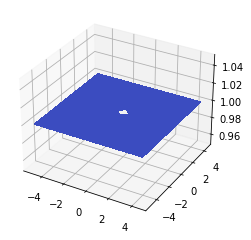

In [5]:
from torch_vector_field import vector_field, utilities, plotting

class TorchToNumpyPotentialFieldWrapper(vector_field.PotentialField):
    def __init__(self, f: nn.Module):
        self.f = f 
    
    def get_value(self, x):
        x_t = torch.from_numpy(x.astype(np.float32))
        with torch.no_grad():
            p_t = self.f(x_t)
        return p_t.detach().cpu().numpy().astype(np.float64)

class QuasiconvexPotentialField(nn.Module):
    def __init__(self, picnn):
        super(QuasiconvexPotentialField, self).__init__()
        self.picnn = picnn

    def forward(self, x):
        r = torch.linalg.norm(x, dim=-1, keepdim=True)
        x_unit = x / r
        return torch.sigmoid(self.picnn(x_unit, r))

potential_field = QuasiconvexPotentialField(
    icnn.PartiallyInputConvexNeuralNetwork([2,8,1], [1,8,1])
)
p_field_wrapped = TorchToNumpyPotentialFieldWrapper(potential_field)
plotting.plot_potential_field(p_field_wrapped, np.array([-5, 5]), np.array([-5, 5]), step_size = 0.5, max_clip = 1000, min_clip=-1000)


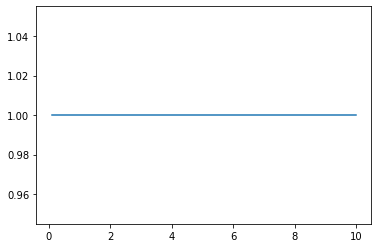

In [6]:
import matplotlib.pyplot as plt

def plot_section(
    p,
    rs: np.ndarray,
    theta: float = 0,
):
    """ Plot a ray along [0, inf] in direction theta """
    fig, ax = plt.subplots()
    values = []
    for r in rs:
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        value = p.get_value(np.array([x,y]))
        values.append(value)
    ax.plot(rs, values)

plot_section(p_field_wrapped, np.linspace(0, 10, 100), theta=3*np.pi/4)

In [43]:
def test_potential_field(p_field):
    p_field_fn, p_field_params, p_field_buffers = make_functional_with_buffers(p_field)

    def p_forward_fn(x):
        """ t is assumed not to have the batch dimension """
        x = x.unsqueeze(0)
        r = torch.linalg.norm(x, dim=-1, keepdim=True)
        x_unit = x / r
        return p_field_fn(p_field_params, p_field_buffers, x_unit, r).squeeze()

    grad_p_fn = grad(p_forward_fn)
    dz = grad_p_fn(torch.zeros(2))
    print(dz.shape)

    dzz = vmap(grad_p_fn)(torch.zeros(5,2))
    print(dzz.shape)

def test_rotational_field(r_field):
    dz = r_field(torch.ones(32,2), torch.ones(32,1))
    print(dz.shape)

def test_smooth_transform(f):

    v = lambda x: x
    f_fn, f_params, f_buffers = make_functional_with_buffers(f)

    def f_forward_fn(x):
        """ x is assumed not to have the batch dimension """ 
        out = f_fn(f_params, f_buffers, x)
        out = out.squeeze() # Function must return scalar 
        return out

    grad_f_fn = jacfwd(f_forward_fn)

    Df = vmap(grad_f_fn)(torch.zeros(32,2))
    Df_inv = vmap(torch.linalg.inv)(Df)

    print("Df_inv: ", Df_inv.shape)
    vfx = v(f(torch.zeros(32,2)))
    print("v(f(x)): ", vfx.shape)
    
    out = vmap(lambda x, y: x @ y)(Df_inv, vfx)
    print("Df_inv(v(f(x))): ", out.shape)

def test_full_net(net):
    dz = net(torch.ones(32,2))
    print(dz.shape)    

test_potential_field(potential_field)
test_rotational_field(rotational_field)
test_smooth_transform(smooth_transform)
test_full_net(net)

torch.Size([2])
torch.Size([5, 2])
torch.Size([32, 2])
Df_inv:  torch.Size([32, 2, 2])
v(f(x)):  torch.Size([32, 2])
Df_inv(v(f(x))):  torch.Size([32, 2])
torch.Size([32, 2])


In [71]:
import torch.optim as optim

def train(
    net: nn.Module, 
    train_loader: torch.utils.data.DataLoader,  
    learning_rate = 1e-3,  
    momentum=0.9,
    n_epochs = 10,
):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimizes
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            if torch.isnan(loss):
                print("For input ", inputs)
                print("Output is ", outputs)
                print("Loss is ", loss)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 10)
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
                running_loss = 0.0

    print('Finished Training')
    return net

In [72]:
def build_baseline_1():
    return nn.Sequential(
        nn.Linear(2, 8),
        nn.ELU(),
        nn.Linear(8,2)
    )

def build_baseline_11():
    v = nn.Sequential(
        nn.Linear(2, 8),
        nn.ELU(),
        nn.Linear(8,2)
    ) 
    smooth_transform = nn.Linear(2,2, bias=False)
    # Set the state dict of smooth_transform
    state_dict = smooth_transform.state_dict()
    state_dict['weight'] = torch.from_numpy(
        np.array(
            [[1.0, 0.5], [0.5, 1.0]]
        ).astype(np.float32)
    )
    smooth_transform.load_state_dict(state_dict)

    # Set transform to be non-learnable
    for param in smooth_transform.parameters():
        param.requires_grad = False

    net = SmoothTransformationVectorField(v, smooth_transform)
    return net

def build_baseline_2():
    v = nn.Sequential(
        nn.Linear(2, 8),
        nn.ELU(),
        nn.Linear(8,2)
    )
    smooth_transform = nn.Sequential(
        nn.Linear(2, 8),
        nn.ELU(),
        nn.Linear(8, 2)
    )

    net = SmoothTransformationVectorField(v, smooth_transform)
    return net

def build_simple_net():
    pass

def build_net():
    potential_field = icnn.PartiallyInputConvexNeuralNetwork([2,8,1], [1,8,1])
    potential_field.reset_parameters()
    rotational_field = RotationalField()
    rotational_field.reset_parameters()  
    combined_field = CombinedVectorField(potential_field, rotational_field)

    smooth_transform = nn.Sequential(
        nn.Linear(2, 8),
        nn.ELU(),
        nn.Linear(8,2)
    )

    net = SmoothTransformationVectorField(combined_field, smooth_transform)
    return net
        

In [73]:
baseline_11 = train(build_baseline_11(), train_loader, n_epochs = 100)

[1,    10] loss: 16.493
[1,    20] loss: 16.631
[1,    30] loss: 12.656
[1,    40] loss: 11.446
[1,    50] loss: 9.207
[1,    60] loss: 8.684
[2,    10] loss: 6.688
[2,    20] loss: 6.137
[2,    30] loss: 4.952
[2,    40] loss: 5.866
[2,    50] loss: 4.667
[2,    60] loss: 5.114
[3,    10] loss: 4.703
[3,    20] loss: 4.796
[3,    30] loss: 4.027
[3,    40] loss: 5.010
[3,    50] loss: 4.186
[3,    60] loss: 4.601
[4,    10] loss: 4.380
[4,    20] loss: 4.704
[4,    30] loss: 3.797
[4,    40] loss: 4.771
[4,    50] loss: 4.050
[4,    60] loss: 4.423
[5,    10] loss: 4.257
[5,    20] loss: 4.605
[5,    30] loss: 3.677
[5,    40] loss: 4.644
[5,    50] loss: 3.961
[5,    60] loss: 4.300
[6,    10] loss: 4.162
[6,    20] loss: 4.514
[6,    30] loss: 3.583
[6,    40] loss: 4.539
[6,    50] loss: 3.883
[6,    60] loss: 4.195
[7,    10] loss: 4.076
[7,    20] loss: 4.424
[7,    30] loss: 3.497
[7,    40] loss: 4.437
[7,    50] loss: 3.805
[7,    60] loss: 4.095
[8,    10] loss: 3.989
[8,    

[59,    60] loss: 0.741
[60,    10] loss: 0.718
[60,    20] loss: 0.799
[60,    30] loss: 0.595
[60,    40] loss: 0.738
[60,    50] loss: 0.670
[60,    60] loss: 0.730
[61,    10] loss: 0.706
[61,    20] loss: 0.788
[61,    30] loss: 0.587
[61,    40] loss: 0.726
[61,    50] loss: 0.661
[61,    60] loss: 0.718
[62,    10] loss: 0.693
[62,    20] loss: 0.776
[62,    30] loss: 0.578
[62,    40] loss: 0.714
[62,    50] loss: 0.652
[62,    60] loss: 0.707
[63,    10] loss: 0.680
[63,    20] loss: 0.765
[63,    30] loss: 0.570
[63,    40] loss: 0.702
[63,    50] loss: 0.642
[63,    60] loss: 0.695
[64,    10] loss: 0.668
[64,    20] loss: 0.754
[64,    30] loss: 0.561
[64,    40] loss: 0.690
[64,    50] loss: 0.633
[64,    60] loss: 0.684
[65,    10] loss: 0.655
[65,    20] loss: 0.743
[65,    30] loss: 0.553
[65,    40] loss: 0.679
[65,    50] loss: 0.623
[65,    60] loss: 0.673
[66,    10] loss: 0.643
[66,    20] loss: 0.731
[66,    30] loss: 0.544
[66,    40] loss: 0.667
[66,    50] loss

SmoothTransformationVectorField(
  (v): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=8, out_features=2, bias=True)
  )
  (f): Linear(in_features=2, out_features=2, bias=False)
)
Parameter containing:
tensor([[1.0000, 0.5000],
        [0.5000, 1.0000]])


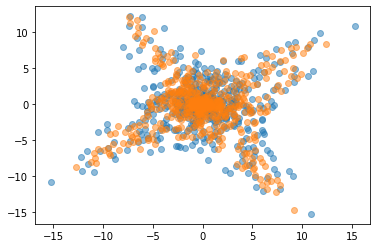

In [74]:

def eval(net, test_ds):
    with torch.no_grad():
        features, targets = test_ds[:]
        preds_np = net(features).detach().cpu().numpy()
        targets_np = targets.detach().cpu().numpy()
        return preds_np, targets_np

print(baseline_11)
print(baseline_11.f.weight)

preds, targets = eval(baseline_11, test_ds)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(targets[:,0], targets[:,1], alpha=0.5)
ax.scatter(preds[:,0], preds[:,1], alpha=0.5)


In [75]:
baseline_1 = train(build_baseline_1(), train_loader, n_epochs = 100)

[1,    10] loss: 15.588
[1,    20] loss: 14.895
[1,    30] loss: 10.467
[1,    40] loss: 8.958
[1,    50] loss: 6.539
[1,    60] loss: 6.257
[2,    10] loss: 5.558
[2,    20] loss: 5.558
[2,    30] loss: 3.955
[2,    40] loss: 4.823
[2,    50] loss: 4.281
[2,    60] loss: 4.583
[3,    10] loss: 4.551
[3,    20] loss: 5.150
[3,    30] loss: 3.813
[3,    40] loss: 4.726
[3,    50] loss: 4.209
[3,    60] loss: 4.468
[4,    10] loss: 4.420
[4,    20] loss: 4.990
[4,    30] loss: 3.751
[4,    40] loss: 4.664
[4,    50] loss: 4.148
[4,    60] loss: 4.391
[5,    10] loss: 4.330
[5,    20] loss: 4.875
[5,    30] loss: 3.708
[5,    40] loss: 4.617
[5,    50] loss: 4.096
[5,    60] loss: 4.332
[6,    10] loss: 4.261
[6,    20] loss: 4.785
[6,    30] loss: 3.669
[6,    40] loss: 4.574
[6,    50] loss: 4.045
[6,    60] loss: 4.280
[7,    10] loss: 4.202
[7,    20] loss: 4.708
[7,    30] loss: 3.631
[7,    40] loss: 4.531
[7,    50] loss: 3.993
[7,    60] loss: 4.231
[8,    10] loss: 4.148
[8,    2

[61,    10] loss: 1.255
[61,    20] loss: 1.380
[61,    30] loss: 0.931
[61,    40] loss: 1.123
[61,    50] loss: 0.992
[61,    60] loss: 1.126
[62,    10] loss: 1.185
[62,    20] loss: 1.300
[62,    30] loss: 0.869
[62,    40] loss: 1.053
[62,    50] loss: 0.929
[62,    60] loss: 1.057
[63,    10] loss: 1.115
[63,    20] loss: 1.221
[63,    30] loss: 0.809
[63,    40] loss: 0.986
[63,    50] loss: 0.868
[63,    60] loss: 0.991
[64,    10] loss: 1.048
[64,    20] loss: 1.146
[64,    30] loss: 0.752
[64,    40] loss: 0.923
[64,    50] loss: 0.812
[64,    60] loss: 0.929
[65,    10] loss: 0.984
[65,    20] loss: 1.074
[65,    30] loss: 0.699
[65,    40] loss: 0.864
[65,    50] loss: 0.761
[65,    60] loss: 0.871
[66,    10] loss: 0.926
[66,    20] loss: 1.008
[66,    30] loss: 0.651
[66,    40] loss: 0.811
[66,    50] loss: 0.715
[66,    60] loss: 0.819
[67,    10] loss: 0.872
[67,    20] loss: 0.948
[67,    30] loss: 0.609
[67,    40] loss: 0.763
[67,    50] loss: 0.674
[67,    60] loss

In [76]:
baseline_2 = train(build_baseline_2(), train_loader, n_epochs = 100)

[1,    10] loss: 17.984
[1,    20] loss: 16.157
[1,    30] loss: 12.967
[1,    40] loss: 11.581
[1,    50] loss: 8.905
[1,    60] loss: 10.143
[2,    10] loss: 11.187
[2,    20] loss: 9.485
[2,    30] loss: 8.678
[2,    40] loss: 8.897
[2,    50] loss: 5.873
[2,    60] loss: 4.972
[3,    10] loss: 4.700
[3,    20] loss: 4.969
[3,    30] loss: 3.631
[3,    40] loss: 4.043
[3,    50] loss: 3.341
[3,    60] loss: 3.986
[4,    10] loss: 3.850
[4,    20] loss: 4.137
[4,    30] loss: 3.048
[4,    40] loss: 3.534
[4,    50] loss: 2.966
[4,    60] loss: 3.514
[5,    10] loss: 3.394
[5,    20] loss: 3.582
[5,    30] loss: 2.669
[5,    40] loss: 3.123
[5,    50] loss: 2.630
[5,    60] loss: 3.087
[6,    10] loss: 2.996
[6,    20] loss: 3.113
[6,    30] loss: 2.301
[6,    40] loss: 2.769
[6,    50] loss: 2.330
[6,    60] loss: 2.662
[7,    10] loss: 2.626
[7,    20] loss: 2.628
[7,    30] loss: 1.887
[7,    40] loss: 2.414
[7,    50] loss: 2.050
[7,    60] loss: 2.297
[8,    10] loss: 2.281
[8,  

[58,    60] loss: 0.138
[59,    10] loss: 0.155
[59,    20] loss: 0.143
[59,    30] loss: 0.122
[59,    40] loss: 0.116
[59,    50] loss: 0.122
[59,    60] loss: 0.134
[60,    10] loss: 0.153
[60,    20] loss: 0.140
[60,    30] loss: 0.119
[60,    40] loss: 0.115
[60,    50] loss: 0.118
[60,    60] loss: 0.130
[61,    10] loss: 0.151
[61,    20] loss: 0.136
[61,    30] loss: 0.117
[61,    40] loss: 0.114
[61,    50] loss: 0.115
[61,    60] loss: 0.127
[62,    10] loss: 0.150
[62,    20] loss: 0.132
[62,    30] loss: 0.114
[62,    40] loss: 0.113
[62,    50] loss: 0.111
[62,    60] loss: 0.125
[63,    10] loss: 0.148
[63,    20] loss: 0.128
[63,    30] loss: 0.112
[63,    40] loss: 0.112
[63,    50] loss: 0.109
[63,    60] loss: 0.123
[64,    10] loss: 0.148
[64,    20] loss: 0.125
[64,    30] loss: 0.110
[64,    40] loss: 0.110
[64,    50] loss: 0.106
[64,    60] loss: 0.120
[65,    10] loss: 0.146
[65,    20] loss: 0.121
[65,    30] loss: 0.109
[65,    40] loss: 0.108
[65,    50] loss

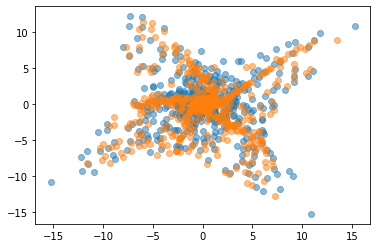

In [77]:
preds, targets = eval(baseline_1, test_ds)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(targets[:,0], targets[:,1], alpha=0.5)
ax.scatter(preds[:,0], preds[:,1], alpha=0.5)



### Testing Smooth Transform Parametrization: (Some Dummy task)(Optional)

### Combining the two: 2D Van Der Pol Oscillator

The VDP loop is nonconvex, hence we need additional smooth transform module on top of the base module. 

The smooth transform module also lets us embed the limit cycle as a low-dimensional manifold in high-dimensional dynamical systems. 

### Karman vortex street

Refer to https://pylbm.readthedocs.io/en/latest/notebooks/07_Von_Karman_vortex_street.html 